In [1]:
# Dem Libraries!
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

Using TensorFlow backend.


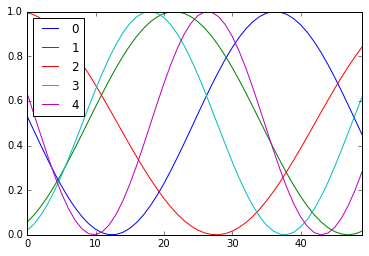

In [2]:
# To get the sine waves data
# n_samples : Number of sine waves you want generated
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
#         print("Offset",offset)
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
#         print("Mul",mul)
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

#Plot 5 sine waves as a test to visually check if it works
ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [3]:
#Generator Model :
# Needs to be able to take in random noise and generate realistic looking output data

def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [4]:
#Discriminator Model :
# Needs to be able to take in a generated signal and distinguish between real and fake(generated)

def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [5]:
# Function to make sure the Discriminators weights are frozen, while training the Generator
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 50)                12250     
_________________________________________________________________
model_2 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [6]:
# Function to get a concatenated input of real_data and fake_data with appropriate concatenated labels
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    # Generated Real Samples 
    XT = sample_data(n_samples=n_samples)
    # Get the random noise that'll be used to generate the fake data
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    # Generate the Fake Samples
    XN = G.predict(XN_noise)
    # Concatenat the Real and Fake Data
    X = np.concatenate((XT, XN))
    # Concatenate the labels and set the appropriate values
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    # Get the real samples for the pretraining of the discriminator
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    # Allow the Discriminator to be trained
    set_trainability(D, True)
    # Fit the Discriminator with 1 epoch
    D.fit(X, y, epochs=1, batch_size=batch_size)


In [7]:
# Perform One Train run for the Determiner
pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - 4s - loss: 0.0071     


In [8]:
# Get sample noise for the GAN training cycle
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

# Training the GAN by backpropagating the losses of the discriminator on the generated samples, 
# whilst freezing discriminator weights

def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    #For each EPOCH
    for epoch in e_range:
        # Get True and Generated Samples with Labels
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        # Allow Discriminator to be Trained
        set_trainability(D, True)
        # Evaluate the Discriminator loss on this set(only to record loss)
        d_loss.append(D.train_on_batch(X, y))
        
        # Now just get the generated samples
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        # Freeze the Discriminator Weights
        set_trainability(D, False)
        # Evaluate the Generator loss on this set
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss


In [9]:
d_loss, g_loss = train(GAN, G, D, verbose=True)

Epoch #50: Generative Loss: 5.1129255294799805, Discriminative Loss: 0.5356324911117554
Epoch #100: Generative Loss: 3.4735636711120605, Discriminative Loss: 0.07482489943504333
Epoch #150: Generative Loss: 4.98911714553833, Discriminative Loss: 0.04559018462896347
Epoch #200: Generative Loss: 3.7669179439544678, Discriminative Loss: 0.056051477789878845
Epoch #250: Generative Loss: 4.215662479400635, Discriminative Loss: 0.03945974260568619
Epoch #300: Generative Loss: 3.600060224533081, Discriminative Loss: 0.05146098509430885
Epoch #350: Generative Loss: 4.199071407318115, Discriminative Loss: 0.026487547904253006
Epoch #400: Generative Loss: 5.056385040283203, Discriminative Loss: 0.015417036600410938
Epoch #450: Generative Loss: 5.073176860809326, Discriminative Loss: 0.009474268183112144
Epoch #500: Generative Loss: 4.7664008140563965, Discriminative Loss: 0.016260061413049698



In [ ]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
#pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()


In [ ]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
instru = open('./trial/instruments.json')

In [ ]:
arr = np.load('./trial/arrays.npz',mmap_mode='r')
on_roll = np.load('./trial/onset_rolls.npz',mmap_mode='r')
pi_roll = np.load('./trial/piano_rolls.npz',mmap_mode='r')

In [ ]:
# To access the name of the Piano Roll files
pi_roll.files

# Once you get the name of the argument you wish to see, 
pi_roll['name of the argurment']

In [ ]:
arr.files

In [ ]:
arr['downbeat_times']

In [ ]:
import json
with open('./trial/instruments.json') as f:
    datastore = json.load(f)

In [ ]:
datastore

In [ ]:
pi_roll.files

In [ ]:
len(pi_roll['0_csc_indptr'])

In [ ]:
pi_roll['0_csc_data']

In [ ]:
len(pi_roll['0_csc_indices'])

In [ ]:
pi_roll['2_csc_indptr']

In [ ]:
pi_roll['0_csc_shape']

In [ ]:
from collections import Counter

In [ ]:
Counter(pi_roll['11_csc_indptr'])

In [ ]:
Counter(pi_roll['10_csc_indices'])

In [ ]:
pi_roll['11_csc_indptr']

In [ ]:
pi_roll['6_csc_indptr']

In [ ]:
pi_roll['5_csc_indptr']

In [ ]:
pi_roll['5_csc_data']

In [ ]:
pi_roll['6_csc_data']

In [ ]:
pi_roll['5_csc_indices']

In [ ]:
pi_roll['6_csc_indices']

In [ ]:
arr['downbeat_times']

In [ ]:
pi_roll['0_csc_shape']

In [ ]:
piano_notes = np.zeros((11520,128))